In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List

In [67]:
pillbox = np.load('images/pillbox.npy')
test = np.load('images/test.npy')
line = np.load('images/line.npy')

In [3]:
def color_models_comparison(img):
    # Plot different color models
    rgb = img.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    rgb_dict = {'rgb': rgb, 'red': rgb[..., 0], 'green': rgb[..., 1], 'blue': rgb[..., 2]}
    hsv_dict = {'hsv': hsv, 'hue': hsv[..., 0], 'saturation': hsv[..., 1], 'value': hsv[..., 2]}
    hls_dict = {'hls': hls, 'hue': hls[..., 0], 'lightness': hls[..., 1], 'saturation': hls[..., 2]}
    lab_dict = {'lab': lab, 'L*': lab[..., 0], 'a*': lab[..., 1], 'b*': lab[..., 2]}
    dicts = [rgb_dict, hsv_dict, hls_dict, lab_dict]

    _, axs = plt.subplots(4, 4, figsize = (12, 10))
    for i, dct in enumerate(dicts):
        for j, (k, v) in enumerate(dct.items()):
            axs[i][j].imshow(v, cmap = 'gray')
            axs[i][j].set_title(k)
            axs[i][j].axis('off')
    plt.show()

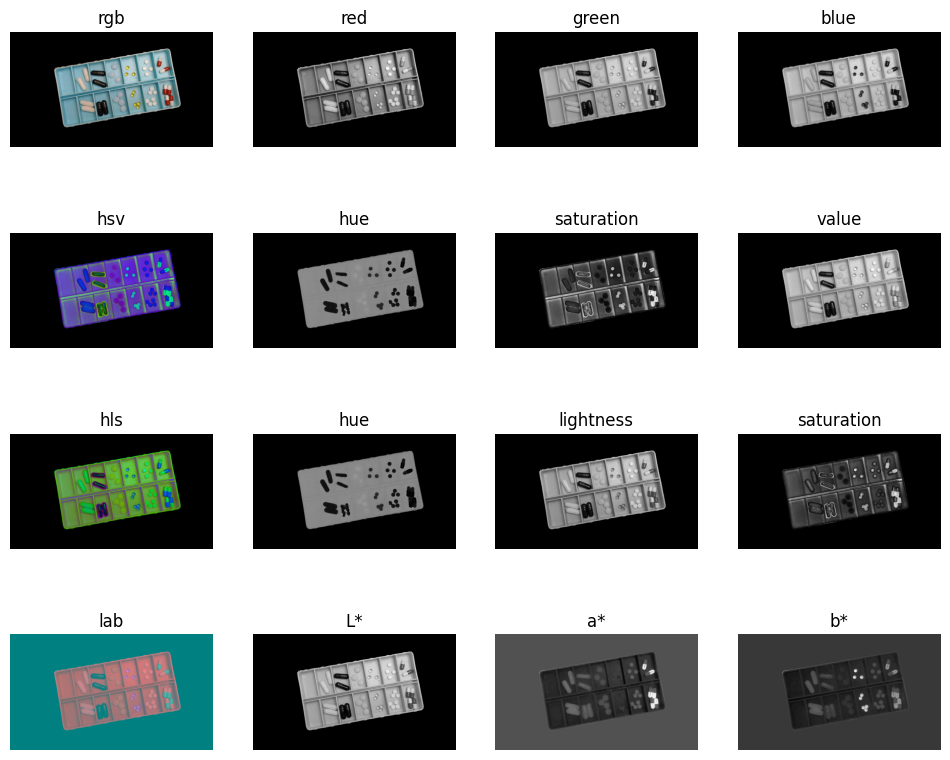

In [4]:
color_models_comparison(pillbox)

### PROBIO

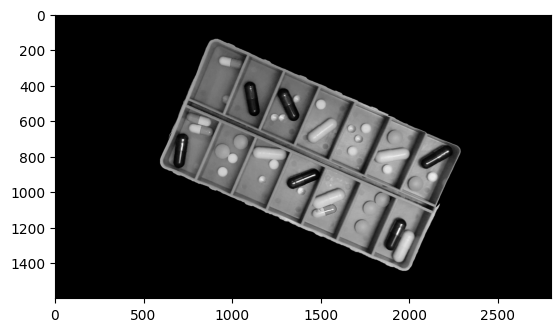

In [74]:
# test1 = cv2.cvtColor(pillbox, cv2.COLOR_RGB2LAB)[..., 1]
test1 = line[..., 0]
plt.imshow(test1, cmap = 'gray')

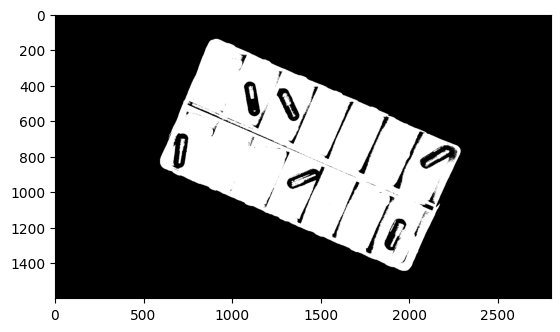

In [76]:
_, binary = cv2.threshold(test1, 45, 255, type = cv2.THRESH_BINARY)

plt.imshow(binary, cmap = 'gray')

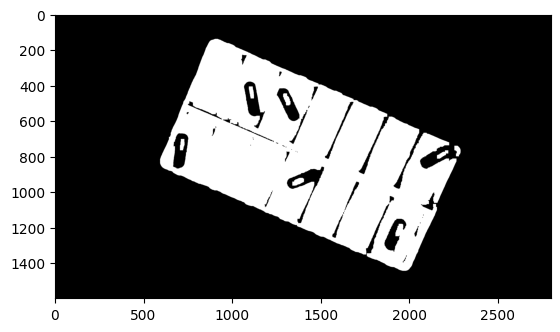

In [80]:
# noise removal
kernel = np.ones((3, 3), np.uint8)
bin_img = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 1)
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations = 8)
plt.imshow(bin_img, cmap = 'gray')

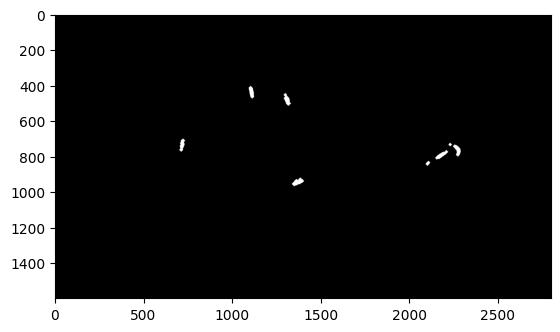

In [79]:
num_labels, labels = cv2.connectedComponents(bin_img, connectivity= 4)
sizes = np.bincount(labels.ravel())
box_idx = np.argmax(sizes[1:]) + 1
bin_img2 = bin_img.copy()

bin_img2[labels == box_idx] = 0

plt.imshow(bin_img2, cmap = 'gray')

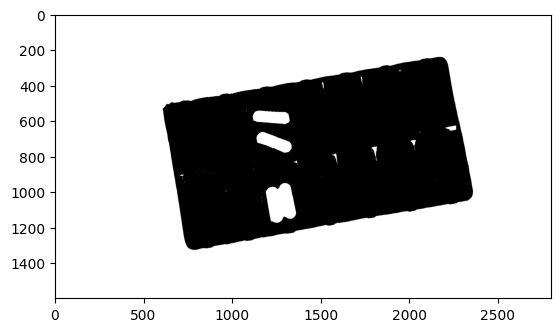

In [34]:
bin_img3 = bin_img.copy()
bin_img3[bin_img2 == 255] = 0
plt.imshow(~bin_img3, cmap = 'gray')

In [45]:
num_labels, labels = cv2.connectedComponents(~bin_img3, connectivity= 4)
sizes = np.bincount(labels.ravel())
sizes

array([1297118, 3125766,      49,     168,     199,       5,       5,
         12671,       5,    1109,      13,   12849,       5,     545,
           783,       5,      10,       5,     417,       1,      65,
           141,       5,       5,      21,       8,       8,       5,
             5,       5,     113,       5,       5,      14,       5,
             8,   27817,       8,      11,       8,       5,       5])

In [55]:
sizess = sizes[2:]
labelss = np.array(list(set(list(labels.flatten())))[2:])
dct = dict(zip(labelss, sizess))

In [58]:
dctt = dict(sorted(dct.items(), key=lambda item: item[1], reverse= True))

In [60]:
dcttt = {k: v for k, v in dctt.items() if v > 10000}
dcttt

{np.int32(36): np.int64(27817),
 np.int32(11): np.int64(12849),
 np.int32(7): np.int64(12671)}

In [65]:
list(dcttt.keys())

[np.int32(36), np.int32(11), np.int32(7)]

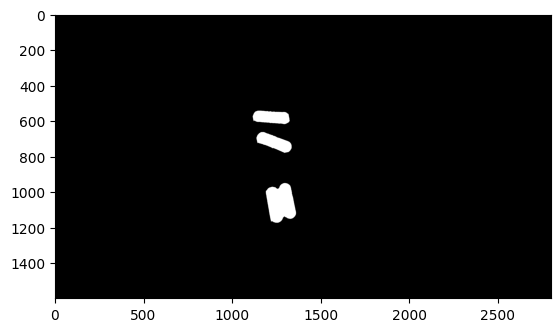

In [66]:
bin_img4 = ~bin_img3.copy()
bin_img4[~np.isin(labels, list(dcttt.keys()))] = 0
plt.imshow(bin_img4, cmap = 'gray')